In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
# Import dataset và các hàm tiền xử lý từ file data_preprocessing.py
from dataset.data_preprocessing import get_dataset, get_transforms
# Import mô hình UNet cải tiến
from src.model.unet import UNet
import numpy as np
import cv2

from PIL import Image
import torchvision.transforms as T
from facenet_pytorch import MTCNN

In [2]:
import warnings

# Chỉ ẩn các FutureWarning phát ra từ module mtcnn của facenet_pytorch
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module=r"facenet_pytorch\.models\.mtcnn"
)

In [3]:
detector = MTCNN(keep_all=True, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [4]:
def visualize_prediction(model, test_loader, device, sample_idx=0, apply_denormalization=False):
    """
    Hiển thị Test Image, Ground Truth Mask, Predicted Mask và Filtered Image.

    Parameters:
      - model: mô hình đã huấn luyện (UNet)
      - test_loader: DataLoader của tập test (lấy batch đầu tiên)
      - device: thiết bị chạy (cpu hoặc cuda)
      - sample_idx: chỉ số mẫu trong batch (phải nằm trong khoảng [0, batch_size-1])
      - apply_denormalization: nếu True, thực hiện denormalize (cho dữ liệu đã normalize)
    """
    model.eval()
    with torch.no_grad():
        for images, masks in test_loader:
            # Ép kiểu ảnh thành float nếu chưa, chuyển về device
            images = images.float().to(device)
            break  # Lấy batch đầu tiên

        # Kiểm tra sample_idx
        if sample_idx < 0 or sample_idx >= images.size(0):
            raise IndexError(f"sample_idx {sample_idx} không hợp lệ với batch size {images.size(0)}")

        orig_image = images[sample_idx].cpu()  # [C, H, W]
        gt_mask = masks[sample_idx].cpu()      # [1, H, W]

        # Đưa ảnh vào mô hình
        input_image = orig_image.unsqueeze(0).float().to(device)
        pred_mask = model(input_image).squeeze(0).cpu()  # [1, H, W]

    # Chuyển đổi ảnh từ tensor sang numpy [H, W, C]
    image_np = orig_image.permute(1, 2, 0).numpy()
    if apply_denormalization:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = image_np * std + mean  # Denormalize
    image_np = np.clip(image_np, 0, 1)

    # Chuyển đổi mask sang numpy
    gt_mask_np = gt_mask.squeeze(0).numpy()
    pred_mask_np = pred_mask.squeeze(0).numpy()  # [H, W]

    # Lấy phần vùng ảnh dựa trên predicted mask
    filtered_image = image_np * pred_mask_np[..., None]

    # Hiển thị kết quả
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(image_np)
    axs[0].set_title("Test Image")
    axs[0].axis("off")

    axs[1].imshow(gt_mask_np, cmap="gray")
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_mask_np, cmap="gray")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    axs[3].imshow(filtered_image)
    axs[3].set_title("Filtered Image")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [6]:
transform = get_transforms(target_size=(256, 256), is_train=True, for_visualization=False)

In [7]:
dataset = get_dataset(
    dataset_mode="celeba",
    transform=transform,
    imgs_folder="../dataset/preprocessed/imgs",
    masks_folder="../dataset/preprocessed/masks"
)

In [8]:
test_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

In [9]:
model = UNet(in_channels=3, out_channels=1, init_features=32, dropout_prob=0.3).to(device)

In [10]:
checkpoint_path = "../src/snapshot/best_unet_model.pth"
if os.path.exists(checkpoint_path):
    # Lưu ý: Nếu checkpoint được lưu ở dạng state_dict thông thường, không cần weights_only
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    print("Model loaded successfully.")
else:
    print(f"Model checkpoint not found at: {checkpoint_path}")
    exit()

Model loaded successfully.


In [11]:
sample_idx = random.randint(0, 7)
print("Sample index:", sample_idx)

Sample index: 2


In [12]:
sample_img_path, sample_mask_path = dataset.samples[sample_idx]
print("Ảnh: ", sample_img_path)
print("Mask:", sample_mask_path)

Ảnh:  ../dataset/preprocessed/imgs\2.jpg
Mask: ../dataset/preprocessed/masks\2.png


In [13]:
def read_image(image_path):
    image = cv2.imread(image_path)  # OpenCV mặc định đọc ảnh dưới dạng BGR
    if image is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")
    # Chuyển đổi từ BGR sang RGB để hiển thị chính xác màu sắc
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [14]:
def read_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Đọc dưới dạng ảnh grayscale
    if mask is None:
        raise FileNotFoundError(f"Không tìm thấy mask: {mask_path}")
    # Áp dụng threshold để mask chỉ có giá trị 0 hoặc 255
    _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
    return mask

In [15]:
display_transform = get_transforms(target_size=(256, 256), for_visualization=True)
orig_image = read_image(sample_img_path)
orig_mask = read_mask(sample_mask_path)
if orig_image.shape[:2] != orig_mask.shape[:2]:
    orig_mask = cv2.resize(orig_mask, (orig_image.shape[1], orig_image.shape[0]), interpolation=cv2.INTER_NEAREST)

In [16]:
disp_aug = display_transform(image=orig_image, mask=orig_mask)
img_disp = disp_aug['image'].permute(1, 2, 0).cpu().numpy()  # Đã có giá trị [0,1]
mask_disp = disp_aug['mask'].squeeze().cpu().numpy()

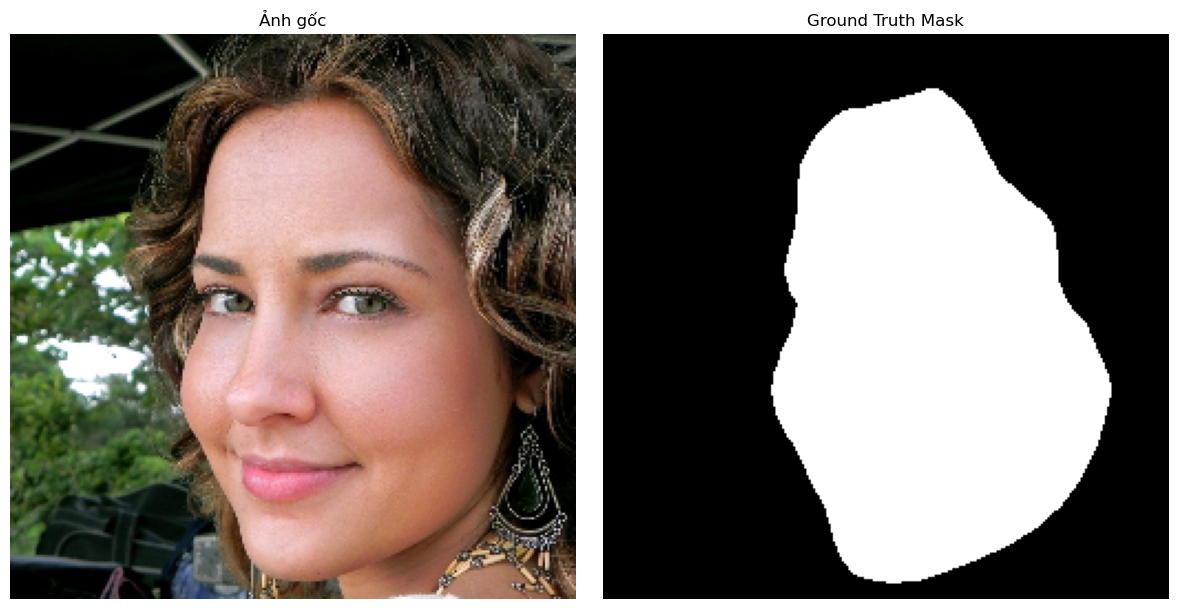

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_disp)
plt.title("Ảnh gốc")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask_disp, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")
plt.tight_layout()
plt.show()

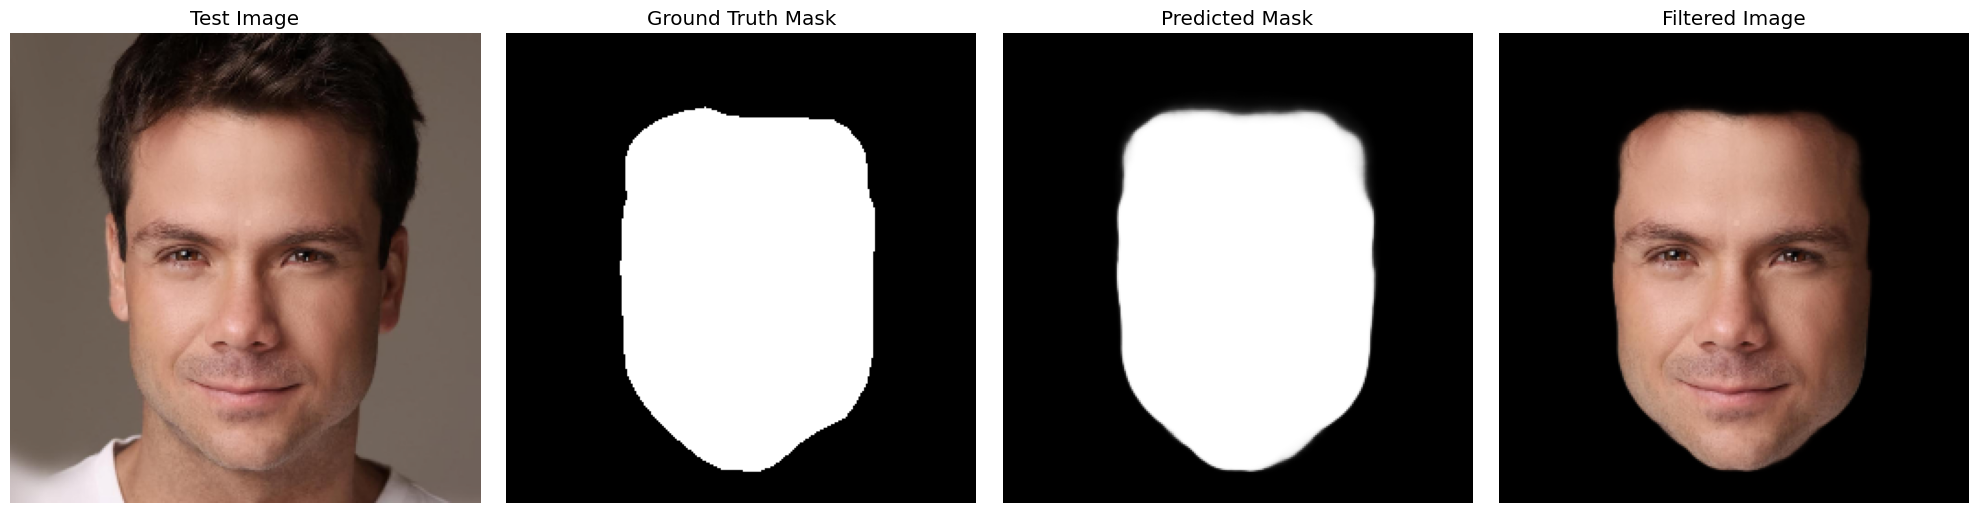

In [148]:
visualize_prediction(model, test_loader, device, sample_idx=sample_idx, apply_denormalization=True)

---

In [18]:
def denormalize(image_tensor):
    """
    Chuyển đổi ảnh đã được normalize về dạng ban đầu để hiển thị đúng màu sắc.
    Giả sử ảnh đã được normalize theo mean=[0.485,0.456,0.406] và std=[0.229,0.224,0.225].
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
    image_np = image_np * std + mean  # Denormalize
    image_np = np.clip(image_np, 0, 1)
    return image_np

In [19]:
def test_new_image(image_path, model, device, transform):
    # Đọc ảnh gốc sử dụng OpenCV và chuyển đổi sang RGB
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Cannot load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augmented = transform(image=image)
    image_tensor = augmented['image']  # shape: [C, H, W]

    # Dự đoán mask bằng mô hình (chú ý thêm batch dimension)
    input_tensor = image_tensor.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        pred_mask = model(input_tensor).squeeze(0).cpu()  # shape: [1, H, W] hoặc [H, W]

    # Denormalize ảnh gốc để hiển thị
    image_disp = denormalize(image_tensor)

    # Chuyển predicted mask sang numpy (squeeze lại nếu cần)
    if pred_mask.dim() == 3:
        pred_mask_np = pred_mask.squeeze(0).numpy()
    else:
        pred_mask_np = pred_mask.numpy()

    # Tạo ảnh filtered: nhân ảnh gốc với predicted mask (broadcast mask lên các kênh)
    filtered_image = image_disp * pred_mask_np[..., None]

    # Hiển thị kết quả
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(image_disp)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(pred_mask_np, cmap="gray")
    axs[1].set_title("Predicted Mask")
    axs[1].axis("off")

    axs[2].imshow(filtered_image)
    axs[2].set_title("Filtered Image")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

In [20]:
transform = get_transforms(target_size=(256, 256), is_train=True, for_visualization=False)

In [21]:
image_path = "../dataset/test/test1.jpg"

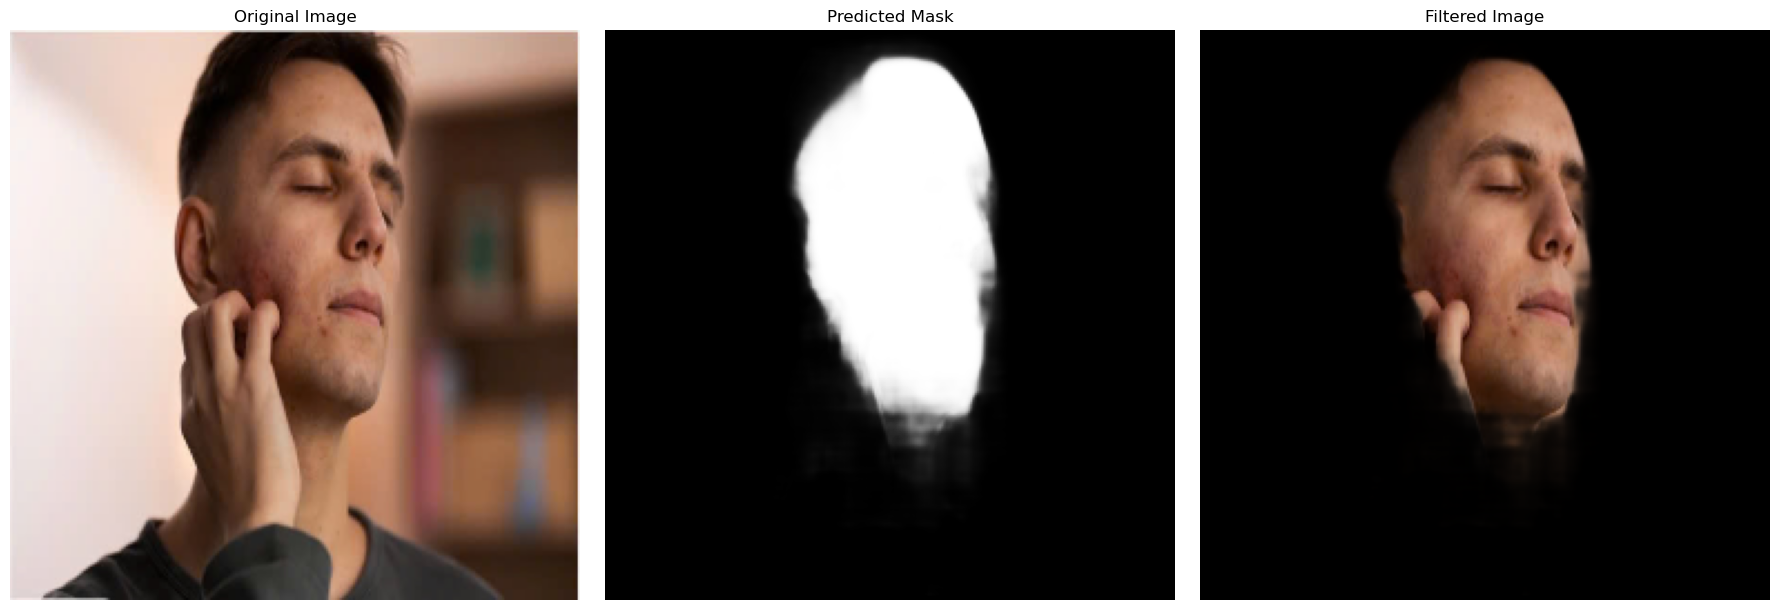

In [22]:
test_new_image(image_path, model, device, transform)

---

In [27]:
def get_skin_mask(image_path, model, device, transform, threshold=0.4):
    """
    Lấy skin mask từ ảnh dựa trên model segmentation.

    Args:
        image_path (str): Đường dẫn đến ảnh gốc.
        model: Model segmentation dùng để dự đoán mask.
        device: Thiết bị thực hiện infer (CPU hoặc GPU).
        transform: Hàm chuyển đổi ảnh (ví dụ: từ Albumentations) trả về dict với key 'image'.
        threshold (float): Ngưỡng phân loại để chuyển mask dự đoán thành nhị phân.

    Returns:
        pred_mask_np (numpy.ndarray): Mảng mask nhị phân có giá trị 0 hoặc 1, dạng numpy array.
    """
    # 1. Đọc ảnh và chuyển sang RGB
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Cannot load image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 2. Áp dụng transform để chuẩn bị đầu vào cho model
    augmented = transform(image=image)
    image_tensor = augmented['image']  # expected shape: [C, H, W]
    print("DEBUG: image_tensor shape:", image_tensor.shape)
    print("DEBUG: image_tensor dtype:", image_tensor.dtype)

    # 3. Thêm batch dimension và đưa vào device
    input_tensor = image_tensor.unsqueeze(0).to(device)

    # 4. Dự đoán mask bằng model và đưa về CPU
    model.eval()
    with torch.no_grad():
        pred_mask = model(input_tensor).cpu()

    # 5. Loại bỏ các dimension có kích thước 1 (batch, channel nếu có)
    pred_mask = pred_mask.squeeze()  # Nếu shape ban đầu là (1, 256, 256) hoặc (1,1,256,256) thì sẽ trở về (256,256)
    print("DEBUG: pred_mask shape sau squeeze:", pred_mask.shape)
    print("DEBUG: pred_mask dtype:", pred_mask.dtype)

    # 6. Áp dụng threshold để biến mask thành nhị phân (0 và 1)
    # Kết quả sau khi .numpy() đã là NumPy array
    pred_mask_np = (pred_mask > threshold).float().numpy()
    print("DEBUG: Unique values sau threshold (NumPy):", np.unique(pred_mask_np))
    pred_mask_np = (pred_mask_np * 255).astype(np.uint8)
    return pred_mask_np


In [28]:
def display_image_and_mask(image_path, model, device, transform, threshold=0.4):
    # 1. Đọc ảnh gốc (RGB)
    orig_image = read_image(image_path)  # shape (H, W, 3)
    print("DEBUG: orig_image shape:", orig_image.shape)
    print("DEBUG: orig_image dtype:", orig_image.dtype)

    # 2. Lấy predicted mask (đã được binarize, mong đợi shape (256,256))
    skin_mask = get_skin_mask(image_path, model, device, transform, threshold=threshold)
    print("DEBUG: skin_mask shape (before resize):", skin_mask.shape)
    print("DEBUG: skin_mask dtype (before resize):", skin_mask.dtype)
    print("DEBUG: Unique values in skin_mask:", np.unique(skin_mask))

    # 3. Resize mask về cùng kích thước ảnh gốc
    h, w = orig_image.shape[:2]
    if skin_mask.dtype != np.uint8:
        skin_mask_8u = (skin_mask * 255).astype(np.uint8)
        print("DEBUG: Converted skin_mask to uint8, unique values:", np.unique(skin_mask_8u))
    else:
        skin_mask_8u = skin_mask
    resized_mask = cv2.resize(skin_mask_8u, (w, h), interpolation=cv2.INTER_NEAREST)
    print("DEBUG: resized_mask shape:", resized_mask.shape)
    print("DEBUG: Unique values in resized_mask:", np.unique(resized_mask))

    # 4. Hiển thị ảnh gốc và mask
    plt.figure(figsize=(12, 6))

    # a) Ảnh gốc
    plt.subplot(1, 2, 1)
    plt.imshow(orig_image)
    plt.title("Original Image")
    plt.axis("off")

    # b) Mask đã resize
    plt.subplot(1, 2, 2)
    plt.imshow(resized_mask, cmap="gray")
    plt.title("Predicted Mask (resized)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [29]:
transform = get_transforms(target_size=(256, 256), is_train=False, for_visualization=False)

DEBUG: orig_image shape: (416, 608, 3)
DEBUG: orig_image dtype: uint8
DEBUG: image_tensor shape: torch.Size([3, 256, 256])
DEBUG: image_tensor dtype: torch.float32
DEBUG: pred_mask shape sau squeeze: torch.Size([256, 256])
DEBUG: pred_mask dtype: torch.float32
DEBUG: Unique values sau threshold (NumPy): [0. 1.]
DEBUG: skin_mask shape (before resize): (256, 256)
DEBUG: skin_mask dtype (before resize): uint8
DEBUG: Unique values in skin_mask: [  0 255]
DEBUG: resized_mask shape: (416, 608)
DEBUG: Unique values in resized_mask: [  0 255]


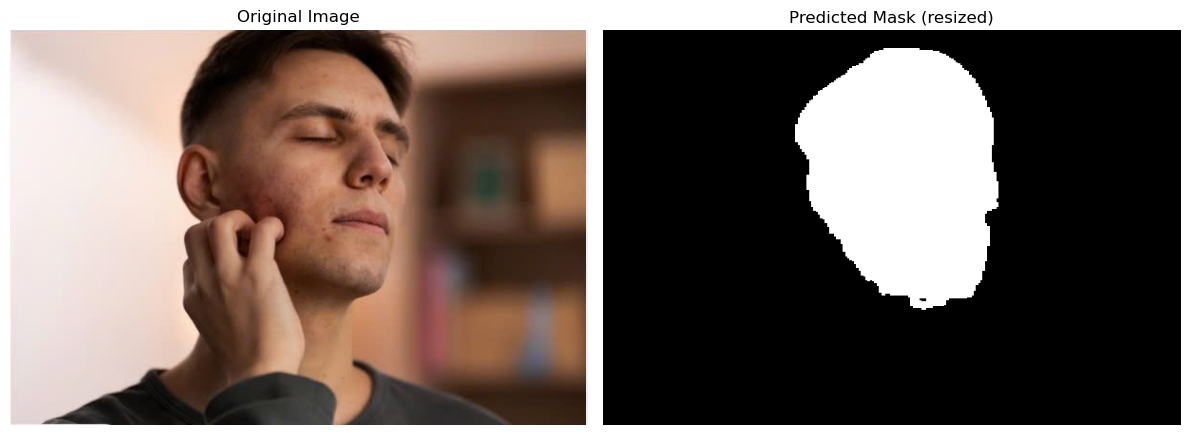

In [30]:
test_image_path = "../dataset/test/test1.jpg"
display_image_and_mask(test_image_path, model, device, transform, threshold=0.4)

---

In [31]:
def draw_contours_on_mask(mask):
    """
    mask: Ảnh nhị phân [H, W] có giá trị 0 hoặc 255
    return: Ảnh mask 3 kênh có vẽ contour (màu xanh dương)
    """
    # Đảm bảo mask có kiểu uint8
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    # Áp dụng threshold (nếu cần, đảm bảo chỉ có 0 hoặc 255)
    _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # Chuyển mask sang ảnh 3 kênh
    mask_color = cv2.cvtColor(mask_bin, cv2.COLOR_GRAY2BGR)
    # Tìm contours
    contours, _ = cv2.findContours(mask_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Vẽ contour lên ảnh (màu xanh dương: BGR (255, 0, 0))
    cv2.drawContours(mask_color, contours, -1, (255, 0, 0), 2)
    # Chuyển đổi sang RGB để hiển thị đúng với matplotlib
    mask_color_rgb = cv2.cvtColor(mask_color, cv2.COLOR_BGR2RGB)
    return mask_color_rgb

In [32]:
def draw_bbox_on_image(image, mask):
    """
    image: Ảnh RGB, float32 [0,1]
    mask: Ảnh nhị phân [0 hoặc 255]
    return: Ảnh RGB với bbox và contour (vẫn đúng màu)
    """
    image_disp = (image * 255).astype(np.uint8).copy()

    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_disp, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.drawContours(image_disp, [cnt], -1, (0, 0, 255), 2)

    image_with_box = image_disp.astype(np.float32) / 255.0
    return image_with_box

In [33]:
def visualize_face_segmentation(image_path, model, device, transform, threshold=0.4):
    """
    Pipeline hiển thị các bước kết quả của quá trình segmentation:
        1. Dự đoán skin mask (256x256)
        2. Resize ảnh gốc về 256x256 đồng bộ với mask
        3. Tạo ảnh filtered (nhân mask với ảnh)
        4. Tính contour trên mask
        5. Vẽ bounding boxes và contour lên ảnh
        6. Hiển thị kết quả các bước
    """
    # 1. Lấy predicted skin mask (256x256) từ model
    skin_mask = get_skin_mask(image_path, model, device, transform, threshold=threshold)
    # skin_mask có kích thước (256,256) với giá trị 0 hoặc 255

    # 2. Đọc ảnh gốc và resize về (256,256) để đồng bộ với mask
    orig_image = read_image(image_path)  # (H, W, 3) với dtype uint8, RGB
    image_resized = cv2.resize(orig_image, (256, 256), interpolation=cv2.INTER_LINEAR)
    image_resized = image_resized.astype(np.float32) / 255.0   # chuyển về float [0,1]

    # 3. Tính ảnh filtered: nhân ảnh với mask (mở rộng mask thành [256,256,1])
    mask_expanded = (skin_mask.astype(np.float32) / 255.0)[..., np.newaxis]
    filtered_image = image_resized * mask_expanded

    # 4. Tính contour từ mask
    contour_img = draw_contours_on_mask(skin_mask)

    # 5. Vẽ bounding boxes và contour lên ảnh (đang vẽ trên không gian 256x256)
    image_with_bbox = draw_bbox_on_image(image_resized, skin_mask)

    # 6. Hiển thị các kết quả
    fig, axs = plt.subplots(1, 5, figsize=(24, 6))

    axs[0].imshow(image_resized)
    axs[0].set_title("Original Image (256x256)")
    axs[0].axis("off")

    axs[1].imshow(skin_mask, cmap="gray")
    axs[1].set_title("Predicted Mask")
    axs[1].axis("off")

    axs[2].imshow(filtered_image)
    axs[2].set_title("Filtered Image")
    axs[2].axis("off")

    axs[3].imshow(contour_img)
    axs[3].set_title("Contour on Mask")
    axs[3].axis("off")

    axs[4].imshow(image_with_bbox)
    axs[4].set_title("Image with BBox & Contour")
    axs[4].axis("off")

    plt.tight_layout()
    plt.show()

In [36]:
test_image_path = "../dataset/test/test1.jpg"

DEBUG: image_tensor shape: torch.Size([3, 256, 256])
DEBUG: image_tensor dtype: torch.float32
DEBUG: pred_mask shape sau squeeze: torch.Size([256, 256])
DEBUG: pred_mask dtype: torch.float32
DEBUG: Unique values sau threshold (NumPy): [0. 1.]


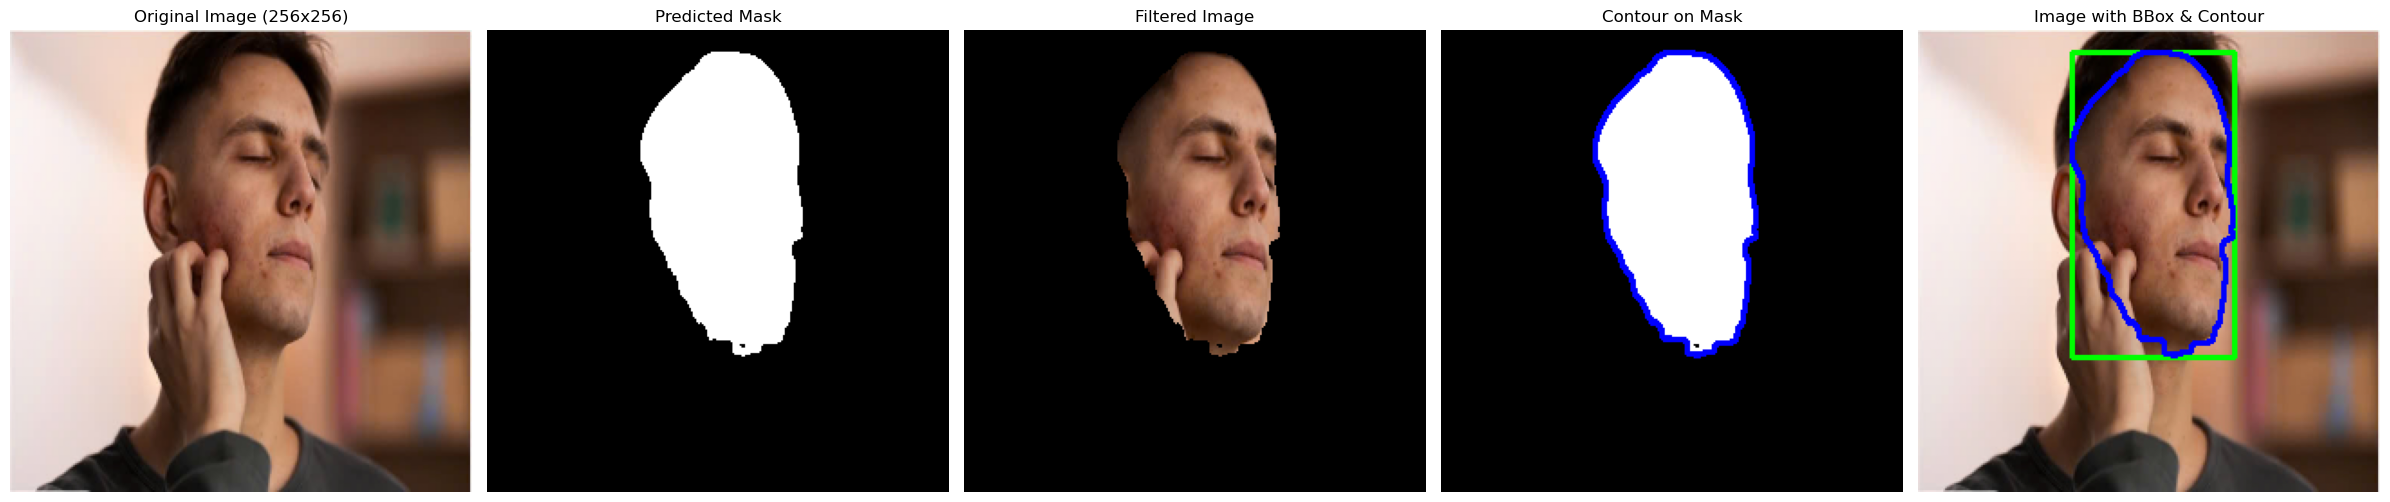

In [37]:
visualize_face_segmentation(test_image_path, model, device, transform, threshold=0.4)

---

### MTCNN

In [38]:
!pip install facenet-pytorch

In [39]:
from facenet_pytorch import MTCNN

In [40]:
def detect_face_mtcnn_from_skin(image_path, skin_mask, min_face_size=20):
    orig_image = cv2.imread(image_path)
    orig_image_rgb = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)

    h, w = orig_image_rgb.shape[:2]
    if skin_mask.shape != (h, w):
        skin_mask = cv2.resize(skin_mask, (w, h), interpolation=cv2.INTER_NEAREST)

    # Áp mặt nạ da lên ảnh RGB (lọc vùng không phải da)
    filtered_image = orig_image_rgb.copy()
    filtered_image[skin_mask == 0] = [255, 255, 255]  # hoặc [0, 0, 0] nếu thích nền đen

    filtered_image_pil = Image.fromarray(filtered_image)

    # Tạo MTCNN detector
    mtcnn = MTCNN(keep_all=True, min_face_size=min_face_size)

    # Phát hiện khuôn mặt và landmark
    boxes, probs, landmarks = mtcnn.detect(filtered_image_pil, landmarks=True)

    result_image = orig_image_rgb.copy()

    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            prob = probs[i]
            print(f"[{i}] Box: {box}, Confidence: {prob:.4f}")

            # Vẽ bounding box
            cv2.rectangle(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{prob:.2f}"
            cv2.putText(result_image, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Vẽ landmark (mắt trái, mắt phải, mũi, miệng trái, miệng phải)
            for (x, y) in landmarks[i]:
                cv2.circle(result_image, (int(x), int(y)), 2, (0, 0, 255), -1)
    else:
        print("Không phát hiện được khuôn mặt bằng MTCNN.")

    return result_image, boxes


---

In [41]:
def full_pipeline_face_detection(image_path, model, device, transform, method='mtcnn', threshold=0.4):
    """
    Quy trình đầy đủ để phát hiện khuôn mặt:
    1. Dự đoán vùng da
    2. Áp dụng bộ phát hiện khuôn mặt
    3. Hiển thị kết quả
    """
    # 1. Dự đoán vùng da
    skin_mask = get_skin_mask(image_path, model, device, transform, threshold=threshold)

    # 2. Áp dụng bộ phát hiện khuôn mặt
    if method == 'mtcnn':
        result_image, boxes = detect_face_mtcnn_from_skin(image_path, skin_mask)
        print("Boxes: ", boxes)
        title = "Phát hiện khuôn mặt bằng MTCNN (trên mặt nạ da)"
    else:
        raise ValueError("Phương pháp không được hỗ trợ. Sử dụng 'mtcnn'.")

    # 3. Hiển thị kết quả
    plt.figure(figsize=(8, 8))
    plt.imshow(result_image)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

DEBUG: image_tensor shape: torch.Size([3, 256, 256])
DEBUG: image_tensor dtype: torch.float32
DEBUG: pred_mask shape sau squeeze: torch.Size([256, 256])
DEBUG: pred_mask dtype: torch.float32
DEBUG: Unique values sau threshold (NumPy): [0. 1.]
[0] Box: [240.80653381347656 31.851917266845703 418.24786376953125
 268.56756591796875], Confidence: 1.0000
Boxes:  [[240.80653381347656 31.851917266845703 418.24786376953125
  268.56756591796875]]


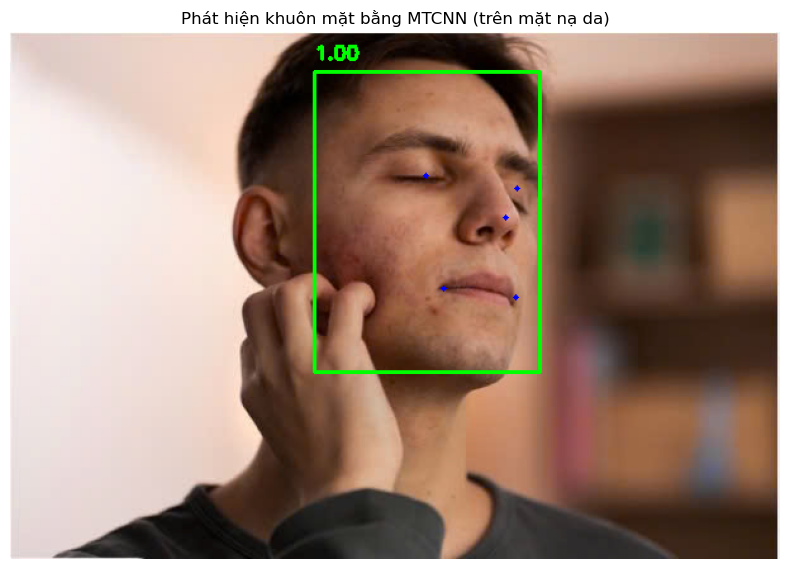

In [42]:
full_pipeline_face_detection(test_image_path, model, device, transform, method='mtcnn')

---

# MUCT DATABASE

In [168]:
import os
import pathlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from PIL import Image
from pathlib import Path
plt.style.use("ggplot")

In [169]:
DATA_DIR = "../dataset/muct"
raw_data = "../dataset/muct/muct"
annotation_file = "../dataset/muct/muct-landmarks/muct76-opencv.csv"

In [170]:
raw_data, annotation_file

('../dataset/muct/muct', '../dataset/muct/muct-landmarks/muct76-opencv.csv')

In [171]:
def load_ground_truth(annotation_file: str) -> dict[str, tuple[int,int,int,int]]:
    ground_truth = {}
    p = Path(annotation_file)
    if not p.exists():
        raise FileNotFoundError(f"Annotation file not found: {annotation_file}")

    with p.open() as f:
        next(f)  # skip header
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 153:
                # cảnh báo rồi bỏ qua dòng thiếu landmark
                print(f"[WARN] Skip {parts[0]}: chỉ có {len(parts)} cột")
                continue
            filename = parts[0] + ".jpg"
            coords = list(map(float, parts[2:]))
            # ghép cặp (x,y)
            pts = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
            xs = [x for x,_ in pts]; ys = [y for _,y in pts]
            x_min, y_min = min(xs), min(ys)
            w, h = max(xs)-x_min, max(ys)-y_min
            ground_truth[filename] = (int(x_min), int(y_min), int(w), int(h))
    return ground_truth


In [172]:
ground_truth = load_ground_truth(annotation_file)

In [173]:
def check_name_consistency(raw_dir: str, ground_truth: dict[str,tuple]) -> None:
    files_on_disk = {f for f in os.listdir(raw_dir) if f.lower().endswith((".jpg",".png"))}
    annots         = set(ground_truth.keys())

    missing = sorted(annots - files_on_disk)
    extra   = sorted(files_on_disk - annots)

    if missing:
        print("⚠️  Thiếu file trên đĩa (có trong CSV nhưng không có):")
        for f in missing: print("   ", f)
    else:
        print("✔️  Không thiếu ảnh theo CSV.")

    if extra:
        print("⚠️  Ảnh thừa trên đĩa (không có trong CSV), liệt kê 10:")
        for f in extra[:10]: print("   ", f)
        if len(extra)>10:
            print(f"   ... và {len(extra)-10} ảnh khác.")
    else:
        print("✔️  Không có ảnh thừa.")

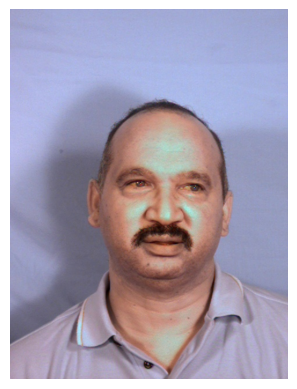

In [174]:
def display_image(image: NDArray[np.float64]) -> None:
    """Display a RGB image

    Args:
        image (NDArray[np.float64]): The image to display, shape (H, W, 3)
    """
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()


img = Image.open("../dataset/muct/muct/i006sa-mn.jpg")
img = np.asarray(img)
if img.shape[-1] == 4:
        img = img[:, :, :3]
display_image(img)

In [175]:
def compute_iou_bbox(box_pred, box_gt):
    x1_p, y1_p, w_p, h_p = box_pred
    x2_p, y2_p = x1_p + w_p, y1_p + h_p
    x1_g, y1_g, w_g, h_g = box_gt
    x2_g, y2_g = x1_g + w_g, y1_g + h_g

    xi1, yi1 = max(x1_p, x1_g), max(y1_p, y1_g)
    xi2, yi2 = min(x2_p, x2_g), min(y2_p, y2_g)
    inter_w   = max(0, xi2 - xi1)
    inter_h   = max(0, yi2 - yi1)
    inter     = inter_w * inter_h

    area_p = w_p * h_p
    area_g = w_g * h_g
    union  = area_p + area_g - inter
    return inter/union if union>0 else float('nan')

In [176]:
def evaluate_dataset_iou(raw_dir, ground_truth,
                         skip_name_check=False,
                         threshold_skin=0.5,
                         min_face_size=20):
    if not skip_name_check:
        check_name_consistency(raw_dir, ground_truth)
        print("-"*50)

    all_ious = []
    for fname, gt_box in ground_truth.items():
        img_path = os.path.join(raw_dir, fname)
        if not os.path.exists(img_path):
            continue

        # tạo skin_mask (bạn tự đảm bảo hàm này đã load model/transform đúng)
        skin = get_skin_mask(img_path, model, device, transform, threshold=threshold_skin)
        _, pred_boxes = detect_face_mtcnn_from_skin(img_path, skin, min_face_size)

        if pred_boxes is None or len(pred_boxes)==0:
            all_ious.append(0.0)
            continue

        # convert format và chọn IoU cao nhất
        preds = [(int(b[0]),int(b[1]),int(b[2]-b[0]),int(b[3]-b[1])) for b in pred_boxes]
        best  = max(compute_iou_bbox(p, gt_box) for p in preds)
        all_ious.append(best)

    # loại NaN
    valid = [i for i in all_ious if not np.isnan(i)]
    mean_iou = float('nan') if not valid else np.mean(valid)
    print(f"Mean IoU trên MUCT ({len(valid)} ảnh): {mean_iou:.4f}")

    # vẽ histogram
    plt.figure(figsize=(6,4))
    plt.hist(valid, bins=20)
    plt.title("IoU Distribution on MUCT")
    plt.xlabel("IoU")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    return mean_iou, all_ious

⚠️  Thiếu file trên đĩa (có trong CSV nhưng không có):
    i000qb-fn.jpg
    i000qc-fn.jpg
    i000qd-fn.jpg
    i000qe-fn.jpg
    i000rb-fn.jpg
    i000rc-fn.jpg
    i000rd-fn.jpg
    i000re-fn.jpg
    i000sb-fn.jpg
    i000sc-fn.jpg
    i000sd-fn.jpg
    i000se-fn.jpg
    i001qb-mn.jpg
    i001qc-mn.jpg
    i001qd-mn.jpg
    i001qe-mn.jpg
    i001rb-mn.jpg
    i001rc-mn.jpg
    i001rd-mn.jpg
    i001re-mn.jpg
    i001sb-mn.jpg
    i001sc-mn.jpg
    i001sd-mn.jpg
    i001se-m2.jpg
    i002qb-mn.jpg
    i002qc-mn.jpg
    i002qd-mn.jpg
    i002qe-mn.jpg
    i002rb-mn.jpg
    i002rc-mn.jpg
    i002rd-mn.jpg
    i002re-mn.jpg
    i002sb-mn.jpg
    i002sc-mn.jpg
    i002sd-mn.jpg
    i002se-mn.jpg
    i003qb-fn.jpg
    i003qc-fn.jpg
    i003qd-fn.jpg
    i003qe-fn.jpg
    i003rb-fn.jpg
    i003rc-fn.jpg
    i003rd-fn.jpg
    i003re-fn.jpg
    i003sb-fn.jpg
    i003sc-fn.jpg
    i003sd-fn.jpg
    i003se-f3.jpg
    i004qb-mn.jpg
    i004qc-mn.jpg
    i004qd-mn.jpg
    i004qe-mn.jpg
    i004r

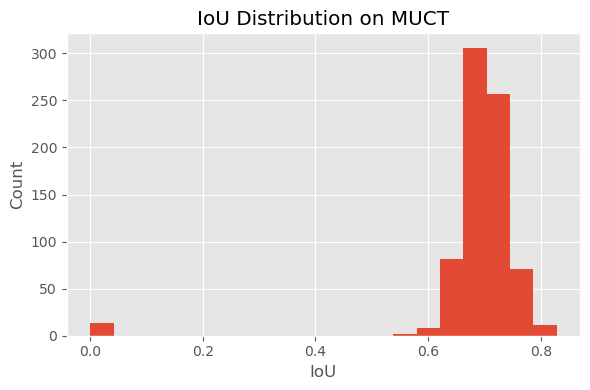

In [177]:
mean_iou, ious = evaluate_dataset_iou(raw_data, ground_truth)

In [3]:
print(mean_iou)

0.75


In [179]:
def compute_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xa, ya = max(x1, x2), max(y1, y2)
    xb, yb = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    inter = max(0, xb - xa) * max(0, yb - ya)
    union = w1 * h1 + w2 * h2 - inter
    return inter / union if union > 0 else 0

In [180]:
def evaluate_detections(preds, gts, iou_threshold=0.5):
    TP, matched = 0, set()
    for pred in preds:
        for i, gt in enumerate(gts):
            if i not in matched and compute_iou(pred, gt) >= iou_threshold:
                TP += 1
                matched.add(i)
                break
    FP = len(preds) - TP
    FN = len(gts) - TP
    return TP, FP, FN, 0

In [181]:
def print_metrics(TP, FP, FN, TN):
    precision = TP / (TP + FP)
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2*(precision*recall)/(precision+recall)
    FDC = FP / (FP+TN)
    print(f"\nDetection Success Count: {recall:.2f}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1_score}")

In [182]:
def evaluate_all_images(raw_data_dir, ground_truth, model, device, transform, iou_threshold=0.5):
    total_TP = total_FP = total_FN = total_TN = 0
    for filename, gt_boxes in ground_truth.items():
        img_path = os.path.join(raw_data_dir, filename)
        if not os.path.exists(img_path):
            continue

        # Obtain predicted boxes from your detection model
        _, pred_boxes = detect_face_mtcnn_from_skin(
            image_path=img_path,
            skin_mask=get_skin_mask(img_path, model, device, transform),
            min_face_size=20
        )

        # Convert predicted boxes to (x, y, w, h) format
        pred_boxes_wh = []
        if pred_boxes is not None:
            for box in pred_boxes:
                x1, y1, x2, y2 = map(int, box)
                pred_boxes_wh.append((x1, y1, x2 - x1, y2 - y1))

        TP, FP, FN, TN = evaluate_detections(pred_boxes_wh, [gt_boxes], iou_threshold)
        total_TP += TP
        total_FP += FP
        total_FN += FN
        total_TN += TN

    # Compute DSC and FDC
    print_metrics(total_TP, total_FP, total_FN, total_TN)

In [ ]:
evaluate_all_images(raw_data, ground_truth, model, device, transform)

DEBUG: image_tensor shape: torch.Size([3, 256, 256])
DEBUG: image_tensor dtype: torch.float32
DEBUG: pred_mask shape sau squeeze: torch.Size([256, 256])
DEBUG: pred_mask dtype: torch.float32
DEBUG: Unique values sau threshold (NumPy): [0. 1.]
[0] Box: [195.19581604003906 232.50717163085938 372.7784423828125 493.4852294921875], Confidence: 0.9992
DEBUG: image_tensor shape: torch.Size([3, 256, 256])
DEBUG: image_tensor dtype: torch.float32
DEBUG: pred_mask shape sau squeeze: torch.Size([256, 256])
DEBUG: pred_mask dtype: torch.float32
DEBUG: Unique values sau threshold (NumPy): [0. 1.]
[0] Box: [183.76324462890625 212.61575317382812 371.9368591308594 491.6876220703125], Confidence: 0.9999
DEBUG: image_tensor shape: torch.Size([3, 256, 256])
DEBUG: image_tensor dtype: torch.float32
DEBUG: pred_mask shape sau squeeze: torch.Size([256, 256])
DEBUG: pred_mask dtype: torch.float32
DEBUG: Unique values sau threshold (NumPy): [0. 1.]
[0] Box: [187.05361938476562 238.41976928710938 395.417205810